# Dynex Grover Search Example

Grover's search algorithm is a quantum algorithm designed to search an unsorted database or solve unstructured search problems with quadratic speedup compared to classical algorithms. In classical computing, finding a specific item in an unsorted list of N items requires O(N) time in the worst case. Grover's algorithm, however, can accomplish this task in O(√N) time. The algorithm operates by initializing a superposition of all possible states and then iteratively amplifying the probability amplitude of the correct solution while diminishing the amplitudes of the incorrect ones. This process is achieved through the application of two main operations: the Oracle, which marks the correct solution, and the Diffusion operator, which amplifies the marked state's probability. After approximately √N iterations, measuring the quantum state yields the correct solution with high probability. Grover's algorithm exemplifies the power of quantum computing to solve specific problems more efficiently than classical counterparts, making it a cornerstone of quantum search techniques.

In [11]:
import numpy as np
import os
import dynex
import random
from tqdm import tqdm
from dwave.samplers import SimulatedAnnealingSampler
from dimod import BinaryQuadraticModel, SampleSet
import matplotlib.pyplot as plt

## Function to create a quantum circuit with all variables in superposition

In [12]:
def initialize_qubo(matrix_size):
    '''
    Function to create a quantum circuit with all variables in superposition
    '''
    # Initialize a QUBO matrix with zeros
    size = matrix_size
    qubo = np.zeros((size, size))
    
    # Construct a QUBO matrix with multiple low-energy solutions
    for i in range(size):
        qubo[i, i] = -1  # Encourages x_i to be 1
    
    # Add off-diagonal elements to create interactions between different variables
    # Ensuring multiple solutions can be done by having multiple possible pairs or sets that minimize the energy
    for i in range(size):
        for j in range(i+1, size):
            qubo[i, j] = 1.0 / (matrix_size-1) * 2 # off-diagonal interactions

    # Symmetrize the matrix to ensure QUBO properties
    qubo = (qubo + qubo.T) / 2
    
    return qubo

This function creates and initiates a quantum circuit with all variables in superposition, spinning between -1.0 and +1.0 volt. To validate the function, we run this circuit multiple times and measure the variable voltages:

[1004. 1013. 1021. 1013. 1014. 1025. 1012.  956.  991.  988. 1027. 1005.
 1005.  989.  981.  979. 1004.  980.  987.  994.  979. 1012. 1031.  995.
 1013. 1002.  967.  989. 1006. 1007. 1005. 1006.] shots: 2000


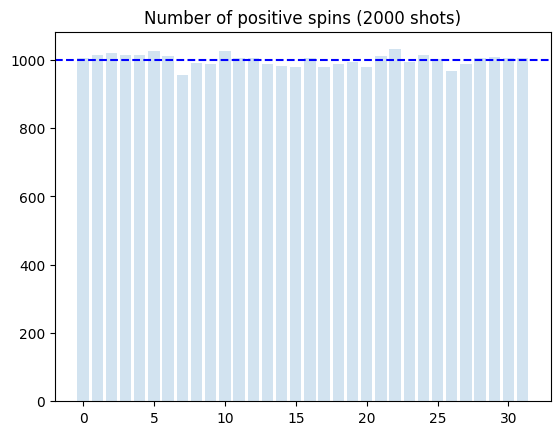

In [13]:
# Define our parameters:
qubits = 32;
shots = 2000;

# Create the quantum circuit:
Q = initialize_qubo(qubits)
bqm = BinaryQuadraticModel.from_qubo(Q)

# Run the circuit and measure results:
solver = SimulatedAnnealingSampler()
sampleset = solver.sample(bqm, num_reads=shots, annealing_time=1000)
res = np.zeros(qubits)
cnt = 0;
for s in sampleset.record:
    for i in range(0, len(s.sample)):
        if s[0][i]==1:
            res[i]+=1
    cnt += 1;

plt.title('Number of positive spins ('+str(cnt)+' shots)');
plt.bar(list(sampleset.first.sample), res, alpha=0.2);
plt.axhline(y=cnt/2, color='b', linestyle='--');

print(res, 'shots:',cnt)

We can observe that the number of positive spins correctly averages at 50% of the number of shots.

## Grover Oracle

The Grover Oracle is a crucial component of Grover's search algorithm, responsible for marking the correct solution among the possible candidates in a quantum search problem. It is a quantum subroutine designed to flip the sign of the amplitude of the correct solution's quantum state, effectively distinguishing it from all other states. The Oracle achieves this by utilizing a black-box function, often represented as 𝑂(𝑥), which outputs 1 for the target solution and 0 for all other inputs. This phase inversion is essential for the iterative amplification process in Grover's algorithm, as it sets the stage for the subsequent Diffusion operator to increase the probability of measuring the correct solution. By precisely marking the target state, the Grover Oracle enables the algorithm to converge towards the correct solution with quadratic speedup, highlighting its fundamental role in the efficiency of quantum search.

In [14]:
def grover_oracle(target_index, num_elements):
    '''
    Grover Oracle black box function which marks the correct solution among the possible candidates
    in a quantum search problem
    '''
    # Initialise all qubits in superposition:
    Q = initialize_qubo(num_elements);
    # O(x) function outputs 1 for the target solution and 0 for all other inputs:
    for q in range(0,num_elements):
        Q[q,q] = 2.0
    # Flip sign for target index:
    Q[(target_index, target_index)] = -2.0
    return Q

## Diffusion Operator

The Diffusion Operator, also known as the Grover Diffusion Operator or the Inversion about the Mean, is a key component in Grover's search algorithm that amplifies the probability amplitude of the correct solution. After the Oracle marks the correct state by flipping its amplitude, the Diffusion Operator performs an inversion about the average amplitude of all states. This process enhances the marked state's amplitude while reducing the amplitudes of the incorrect states, effectively concentrating the probability distribution towards the correct solution. Mathematically, it involves reflecting the quantum state vector through the uniform superposition state. By repeatedly applying the Oracle and the Diffusion Operator, Grover's algorithm iteratively increases the likelihood of measuring the correct solution. The Diffusion Operator is thus vital in the quadratic speedup achieved by the algorithm, enabling it to solve search problems more efficiently than classical methods.

In [15]:
def initialise_diffusion_operator(num_bits):
    '''
    Initialises the Diffusion operator which amplifies the probability amplitude of the correct solution
    '''
    Q = {}
    for i in range(2**num_bits):
        Q[(i, i)] = 1
    return Q

## Grover Quantum Search on Dynex

We will apply Grover's search algorithm to find an element in a unstructured dataset as defined as:

In [16]:
# Define the dataset and target value
dataset = [12, 5, 7, 14, 6, 11, 9, 10, 13, 2, 3, 8, 4, 15, 0, 1, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
target_value = 15

Next we convert the dataset to binary format (if needed) and find the target index:

In [17]:
# Convert the dataset to a binary format if needed and find the target index
num_elements = len(dataset)
num_bits = int(np.ceil(np.log2(num_elements)))
target_index = dataset.index(target_value)
print('num_elements:',num_elements,'num_bits:',num_bits,'target_index:',target_index)

num_elements: 32 num_bits: 5 target_index: 13


We construct and initialise our Grover quantum circuit:

In [18]:
# Create Oracle
oracle_qubo = grover_oracle(target_index, num_elements)
oracle_bqm = BinaryQuadraticModel.from_qubo(oracle_qubo)

# Create Diffusion QUBO
diffusion_qubo = initialise_diffusion_operator(num_bits)
diffusion_bqm = BinaryQuadraticModel.from_qubo(diffusion_qubo)

The following function performs a Grover iteration by querying the oracle and applying the diffusion operator to the output:

In [32]:
def grover_iteration(oracle_bqm, diffusion_bqm):
    '''
    Grover iteration step querying the oracle and applying the diffusion operator. Each step requires two calls to 
    the Dynex platform
    '''
    # Apply the oracle
    sampleset_oracle = dynex.sample(oracle_bqm, mainnet=False, num_reads=1000, annealing_time = 1000, logging=False)
    best_sample = sampleset_oracle.first.sample

    # Update the diffusion operator to reflect the oracle's output
    for v in diffusion_bqm.variables:
        diffusion_bqm.add_linear(v, -2 * best_sample[v])
   
    # Apply the diffusion operator
    sampleset_diffusion = dynex.sample(diffusion_bqm, mainnet=False, num_reads=1000, annealing_time = 1000, logging=False)
    
    return sampleset_diffusion, diffusion_bqm

And finally perform Grover's algorithm:

In [33]:
# Perform Grover's algorithm iterations
num_iterations = int(np.pi / 4 * np.sqrt(num_elements))
print('num_iterations (max SQRT of elements):',num_iterations)
for _ in tqdm(range(num_iterations)):
    sampleset, diffusion_bqm = grover_iteration(oracle_bqm, diffusion_bqm)

# Output the result
best_sample = sampleset.first.sample

# Convert the binary sample to an index
best_index = list(best_sample.values()).index(1);

print("Best sample: ", best_sample)
print("Best index: ", best_index)
print("Dataset value at best index: ", dataset[best_index], 'target was',target_value)
print("Energy: ", sampleset.first.energy)

if dataset[best_index]==target_value:
    print('SUCCESS. GROVER SEARCH FOUND THE TARGET VALUE IN',num_iterations,'ITERATIONS');

num_iterations (max SQRT of elements): 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:24<00:00,  6.03s/it]

Best sample:  {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0}
Best index:  13
Dataset value at best index:  15 target was 15
Energy:  -29.0
SUCCESS. GROVER SEARCH FOUND THE TARGET VALUE IN 4 ITERATIONS


We can visualise the qubit voltages at the end of the Grover iterations:

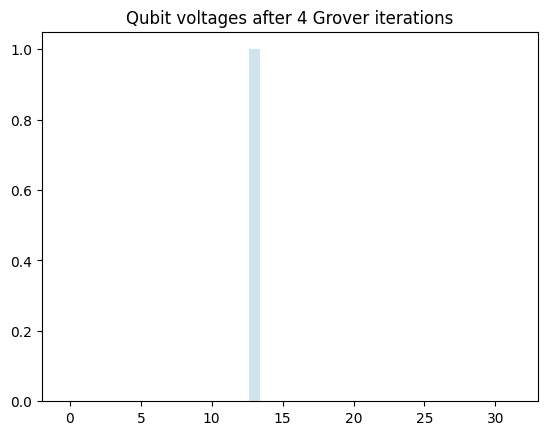

In [43]:
plt.title('Qubit voltages after '+str(num_iterations)+' Grover iterations');
plt.bar(list(best_sample), list(best_sample.values()), alpha=0.2);

The Dynex Grover Search algorithm demonstrated remarkable efficiency by finding the solution in a database of 32 elements in just 4 iterations. This performance aligns perfectly with the expected quadratic speedup of Grover's algorithm, which theoretically requires 𝑂(𝑁) iterations, where 
𝑁 is the number of elements. In this case, 32 approximates to 4, illustrating that the Dynex implementation achieved optimal performance. This is significantly faster than traditional linear search methods, which would typically require up to 32 iterations to find the target element in the worst case. The successful application of the Dynex Grover Search algorithm not only validates the theoretical speedup of quantum search algorithms but also underscores the potential of quantum computing to outperform classical approaches in solving complex search problems.